In [1]:

import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
from pathlib import Path
import time
import math
from numba import jit
dir_vtk = Path("usableVTK")
dir_vtk.mkdir(parents=True, exist_ok=True)

## Assemble Coefficient Matrix


In [2]:

def assemble_matrix(Lx,Ly,Nx,Ny,mu,rho,vin,scaleFactor):
    
    #grid spacing
    dx = Lx/Nx
    dy = Ly/Ny
    vis = mu/rho
    
    #-----COEFFICIENTS----
    #X-MOM and Y_MOM
    #velocities
    ax = vis*dy/dx
    ay = vis*dx/dy
    ap = -2*(ax+ay)
    #pressures
    cx = dy/(2*rho)
    cy = dx/(2*rho)
    
    #CONTINUITY
    #velocities
    ex = dy/2
    ey = dx/2
    
    #smoothing term
    D = -ScaleFactor*dx*dy/((2*mu*dy)/dx+(2*mu*dx)/dy)
    
    #LHS Pressure Gradient
    Sx = (D*dy)/dx
    Sy = (D*dx)/dy
    Sp = -2*(Sx+Sy)

    
    eqs = 3 #3 equations (momentum x, y and continuity)
    
    # total number of cells
    M = int(Nx*Ny)
    
    #Initialise coefficient matrix
    A = np.zeros((eqs*M, eqs*M))
     #Initialise source vector
    b = np.zeros((eqs*M, 1))
   
    internal = (Nx-2)*(Ny-2)
    corners = 4
    horizontal_sides = (Nx-2)*2
    vertical_side = (Ny-2)
    numNonZeros = int(20*horizontal_sides+19*vertical_side+20*vertical_side+66+internal*23) #20 by inlet,bot,top, 
    #19 by outlet, 66 for corners, 23 for internal
    
    data = np.zeros((numNonZeros))
    row_idx = np.zeros((numNonZeros ))
    col_idx = np.zeros((numNonZeros ))
    
    #get indices of corner cells
    botright = eqs*(Nx-1)
    topleft = eqs*(Nx*(Ny-1))
    topright = eqs*(Nx*Ny-1)
    
    #Loop through each cell i
    
    coeffi=0
    for i in range(0, eqs*M, eqs):
        
        #CORNERS
        #bottom left
        if i == 0:
            #X-MOM
            #-------#
            #RHS
            b[i] = -2*ax*vin[0]
            #LHS
            
            #vpx
            data[coeffi] = -3*ax-3*ay  
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            #vex
            data[coeffi] = ax  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+3
            
            coeffi+=1
            #vnx
            data[coeffi] = ay  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+eqs*Nx
            
            coeffi+=1
            #Pe
            data[coeffi] = -cx  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+5
            
            coeffi+=1
            #Pp
            data[coeffi] = cx  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+2
            
            coeffi+=1
            
            #Y-MOM
            #-------#
            #RHS
            b[i+1] = -2*ax*vin[1]
            #LHS
            
            #vpy
            data[coeffi] = -3*ax-3*ay  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vey
            data[coeffi] = ax  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+4
            
            coeffi+=1
            #vny
            data[coeffi] = ay  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            #Pn
            data[coeffi] = -cy
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+2
            
            coeffi+=1
            #Pp
            data[coeffi] = cy  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+2
            
            coeffi+=1
            
            #CONTINUITY
            #-------#
            #LHS
            
            #vpx
            data[coeffi] = ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i
            
            coeffi+=1
            #vpy
            data[coeffi] = ey  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+1
            
            coeffi+=1
            
            #vex
            data[coeffi] = ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vny
            data[coeffi] = ey  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            
            #Pe
            data[coeffi] = Sx
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Pn
            data[coeffi] = Sy  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+eqs*Nx+2
            
            coeffi+=1
            
            #Pp
            data[coeffi] = Sp/2  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+2
            
            coeffi+=1
           
        #bottom right
        elif i == botright:
            #X-MOM
            #-------#
            #RHS
            b[i] = 0
            #LHS
            
            #vpx
            data[coeffi] = -ax-3*ay  
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            #vwx
            data[coeffi] = ax  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-3
            
            coeffi+=1
            #vnx
            data[coeffi] = ay  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+eqs*Nx
            
            coeffi+=1
            #Pw
            data[coeffi] = (4/3)*cx  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-1
            
            coeffi+=1

            #Y-MOM
            #-------#
            #RHS
            b[i+1] = 0
            #LHS
            
            #vpy
            data[coeffi] = -ax-3*ay  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vwy
            data[coeffi] = ax  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-2
            
            coeffi+=1
            #vny
            data[coeffi] = ay  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            #Pn
            data[coeffi] = -cy
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+2
            
            coeffi+=1
            #Pp
            data[coeffi] = cy  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+2
            
            coeffi+=1
            
            #CONTINUITY
            #-------#
 
            #LHS
            
            #vpx
            data[coeffi] = ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i
            
            coeffi+=1
            #vpy
            data[coeffi] = ey  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+1
            
            coeffi+=1
            
            #vwx
            data[coeffi] = -ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #vny
            data[coeffi] = ey  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            
#             #Pw
#             data[coeffi] = Sx
#             row_idx[coeffi] = i+2
#             col_idx[coeffi] = i-1
            
#             coeffi+=1
            
#             #Pn
#             data[coeffi] = Sy  
#             row_idx[coeffi] = i+2
#             col_idx[coeffi] = i+eqs*Nx+2
            
#             coeffi+=1
            
#             #Pp
#             data[coeffi] = -3*Sx-Sy  
#             row_idx[coeffi] = i+2
#             col_idx[coeffi] = i+2
            
#             coeffi+=1
            
        #Top Left
        elif i == topleft:
            #X-MOM
            #-------#
            #RHS
            b[i] = -2*ax*vin[0]
            #LHS
            
            #vpx
            data[coeffi] = -3*ax-3*ay  
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            #vex
            data[coeffi] = ax  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+3
            
            coeffi+=1
            #vsx
            data[coeffi] = ay  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-eqs*Nx
            
            coeffi+=1
            #Pe
            data[coeffi] = -cx  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Pp
            data[coeffi] = cx  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+2
            
            coeffi+=1

            #Y-MOM
            #-------#
            #RHS
            b[i+1] = -2*ax*vin[1]
            #LHS
            
            #vpy
            data[coeffi] = -3*ax-3*ay  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vey
            data[coeffi] = ax  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+4
            
            coeffi+=1
            #vsy
            data[coeffi] = ay  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            #Ps
            data[coeffi] = cy
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1
            #Pp
            data[coeffi] = -cy  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+2
            
            coeffi+=1
     
            #CONTINUITY
            #-------#

            #LHS
            
            #vpx
            data[coeffi] = ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i
            
            coeffi+=1
            #vpy
            data[coeffi] = -ey  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+1
            
            coeffi+=1
            
            #vex
            data[coeffi] = ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vsy
            data[coeffi] = -ey  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            
            #Pe
            data[coeffi] = Sx
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Ps
            data[coeffi] = Sy  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1
            
            #Pp
            data[coeffi] = Sp/2  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+2
            
            coeffi+=1
     
        #top right
        elif i == topright:
            #X-MOM
            #-------#
            #RHS
            b[i] = 0
            #LHS
            
            #vpx
            data[coeffi] = -ax-3*ay  
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            #vwx
            data[coeffi] = ax  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-3
            
            coeffi+=1
            #vsx
            data[coeffi] = ay  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-eqs*Nx
            
            coeffi+=1
            #Pw
            data[coeffi] = (4/3)*cx
            row_idx[coeffi] = i
            col_idx[coeffi] = i-1
            
            coeffi+=1
               
            #Y-MOM
            #-------#
            #RHS
            b[i+1] = 0
            #LHS
            
            #vpy
            data[coeffi] = -ax-3*ay  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vwy
            data[coeffi] = ax  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-2
            
            coeffi+=1
            #vsy
            data[coeffi] = ay  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            #Ps
            data[coeffi] = cy
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1
            #Pp
            data[coeffi] = -cy  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+2
            
            coeffi+=1

            #CONTINUITY
            #-------#

            #LHS
            
            #vpx
            data[coeffi] = ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i
            
            coeffi+=1
            #vpy
            data[coeffi] = -ey  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+1
            
            coeffi+=1
            
            #vwx
            data[coeffi] = -ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #vsy
            data[coeffi] = -ey  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            
#             #Pw
#             data[coeffi] = Sx
#             row_idx[coeffi] = i+2
#             col_idx[coeffi] = i-1
            
#             coeffi+=1
            
#             #Ps
#             data[coeffi] = Sy  
#             row_idx[coeffi] = i+2
#             col_idx[coeffi] = i-eqs*Nx+2
            
#             coeffi+=1
            
#             #Pp
#             data[coeffi] = -3*Sx-Sy  
#             row_idx[coeffi] = i+2
#             col_idx[coeffi] = i+2
            
#             coeffi+=1
            
        #SIDES
        #bottom
        elif 0 < i < botright:
            #X-MOM
            #-------#
            #RHS
            b[i] = 0
            #LHS
            #vpx
            data[coeffi] = -2*ax-3*ay  
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            #vwx
            data[coeffi] = ax  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #vex
            data[coeffi] = ax  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vnx
            data[coeffi] = ay  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+eqs*Nx
            
            coeffi+=1
            #Pw
            data[coeffi] = cx  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-1
            
            coeffi+=1
            
            #Pe
            data[coeffi] = -cx  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Y-MOM
            #-------#
            #RHS
            b[i+1] = 0
            #LHS
            #vpy
            data[coeffi] = -2*ax-3*ay  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vwy
            data[coeffi] = ax  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-2
            
            coeffi+=1
            
            #vey
            data[coeffi] = ax  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+4
            
            coeffi+=1
            #vny
            data[coeffi] = ay  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            #Pn
            data[coeffi] = -cy
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+2
            
            coeffi+=1
            #Pp
            data[coeffi] = cy  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+2
            
            coeffi+=1
    
            #CONTINUITY
            #-------#

            #LHS
            
            #vpy
            data[coeffi] = ey  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+1
            
            coeffi+=1
            
            #vwx
            data[coeffi] = -ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #vex
            data[coeffi] = ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vny
            data[coeffi] = ey  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            
            #Pw
            data[coeffi] = Sx
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-1
            
            coeffi+=1
            
            #Pe
            data[coeffi] = Sx
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Pn
            data[coeffi] = Sy  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+eqs*Nx+2
            
            coeffi+=1
            
            #Pp
            data[coeffi] = -2*Sx-Sy  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+2
            
            coeffi+=1
           
        #top
        elif topleft < i < topright:
            #X-MOM
            #-------#
            #RHS
            b[i] = 0
            #LHS
            
            #vpx
            data[coeffi] = -2*ax-3*ay  
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            #vwx
            data[coeffi] = ax  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #vex
            data[coeffi] = ax  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vsx
            data[coeffi] = ay  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-eqs*Nx
            
            coeffi+=1
            #Pw
            data[coeffi] = cx  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-1
            
            coeffi+=1
            
            #Pe
            data[coeffi] = -cx  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Y-MOM
            #-------#
            #RHS
            b[i+1] = 0
            #LHS
            
            #vpy
            data[coeffi] = -2*ax-3*ay  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vwy
            data[coeffi] = ax  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-2
            
            coeffi+=1
            
            #vey
            data[coeffi] = ax  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+4
            
            coeffi+=1
            #vsy
            data[coeffi] = ay  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            #Ps
            data[coeffi] = cy
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1
            #Pp
            data[coeffi] = -cy  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+2
            
            coeffi+=1

            #CONTINUITY
            #-------#

            #LHS
            
            #vpy
            data[coeffi] = -ey  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+1
            
            coeffi+=1
            
            #vwx
            data[coeffi] = -ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #vex
            data[coeffi] = ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vsy
            data[coeffi] = -ey  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            
            #Pw
            data[coeffi] = Sx
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-1
            
            coeffi+=1
            
            #Pe
            data[coeffi] = Sx
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Ps
            data[coeffi] = Sy  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1
            
            #Pp
            data[coeffi] = -2*Sx-Sy  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+2
            
            coeffi+=1
            
        #left / Inlet
        elif i in range(eqs*Nx,topleft,eqs*Nx):
            #X-MOM
            #-------#
            #RHS
            b[i] = -2*ax*vin[0]
            #LHS
            
             #vpx
            data[coeffi] = -3*ax-2*ay  
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            #vex
            data[coeffi] = ax  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vnx
            data[coeffi] = ay  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+eqs*Nx
            
            coeffi+=1
            
            #vsx
            data[coeffi] = ay  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-eqs*Nx
            
            coeffi+=1
            #Pe
            data[coeffi] = -cx  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Pp
            data[coeffi] = cx  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+2
            
            coeffi+=1
            
            #Y-MOM
            #-------#
            #RHS
            b[i+1] = -2*ax*vin[1]
            #LHS
            #vpy
            data[coeffi] = -3*ax-2*ay  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vey
            data[coeffi] = ax  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+4
            
            coeffi+=1
            
            #vny
            data[coeffi] = ay  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            
            #vsy
            data[coeffi] = ay  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            #Ps
            data[coeffi] = cy  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1
            
            #Pn
            data[coeffi] = -cy  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+2
            
            coeffi+=1

            #CONTINUITY
            #-------#

            #LHS
            
            #vpx
            data[coeffi] = ex  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i
            
            coeffi+=1
            
            #vny
            data[coeffi] = ey
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            
            #vsy
            data[coeffi] = -ey
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            
            #vex
            data[coeffi] = ex 
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #Pe
            data[coeffi] = Sx
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Pn
            data[coeffi] = Sy
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+eqs*Nx+2
            
            coeffi+=1
            
            #Ps
            data[coeffi] = Sy  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1
            
            #Pp
            data[coeffi] = -Sx-2*Sy  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+2
            
            coeffi+=1
    
        #right / Outlet
        elif i in range(botright+eqs*Nx,topright,eqs*Nx):
            
            #X-MOM
            #-------#
            #RHS
            b[i] = 0
            #LHS
            
             #vpx
            data[coeffi] = -ax-2*ay  
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            #vwx
            data[coeffi] = ax  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #vnx
            data[coeffi] = ay  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+eqs*Nx
            
            coeffi+=1
            
            #vsx
            data[coeffi] = ay  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-eqs*Nx
            
            coeffi+=1
            #Pw
            data[coeffi] = (4/3)*cx 
            row_idx[coeffi] = i
            col_idx[coeffi] = i-1
            
            coeffi+=1
    
            
            #Y-MOM
            #-------#
            #RHS
            b[i+1] = 0
            #LHS
            
            #vpy
            data[coeffi] = -ax-2*ay  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vwy
            data[coeffi] = ax  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-2
            
            coeffi+=1
            
            #vny
            data[coeffi] = ay  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            
            #vsy
            data[coeffi] = ay  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            #Pn
            data[coeffi] = -cy
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+2
            
            coeffi+=1
            
            #Ps
            data[coeffi] = cy
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1

            
            #CONTINUITY
            #-------#

            #LHS
            
            #vpx
            data[coeffi] = ex  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i
            
            coeffi+=1
            
            #vny
            data[coeffi] = ey
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            
            #vsy
            data[coeffi] = -ey
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            
            #vwx
            data[coeffi] = -ex 
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-3
            
            coeffi+=1
#             #Pw
#             data[coeffi] = Sx
#             row_idx[coeffi] = i+2
#             col_idx[coeffi] = i-1
            
#             coeffi+=1
            
#             #Pn
#             data[coeffi] = Sy
#             row_idx[coeffi] = i+2
#             col_idx[coeffi] = i+eqs*Nx+2
            
#             coeffi+=1
            
#             #Ps
#             data[coeffi] = Sy  
#             row_idx[coeffi] = i+2
#             col_idx[coeffi] = i-eqs*Nx+2
            
#             coeffi+=1
            
#             #Pp
#             data[coeffi] = Sp-Sx  
#             row_idx[coeffi] = i+2
#             col_idx[coeffi] = i+2
            
#             coeffi+=1
        else:
            #X-MOM
            #-------#
            #RHS
            b[i] = 0
            #LHS
            
            #vpx
            data[coeffi] = ap 
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            #vwx
            data[coeffi] = ax  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #vex
            data[coeffi] = ax  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vnx
            data[coeffi] = ay  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+eqs*Nx
            
            coeffi+=1
            
            #vsx
            data[coeffi] = ay  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-eqs*Nx
            
            coeffi+=1
            #Pw
            data[coeffi] = cx 
            row_idx[coeffi] = i
            col_idx[coeffi] = i-1
            
            coeffi+=1
            
            #Pe
            data[coeffi] = -cx 
            row_idx[coeffi] = i
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Y-MOM
            #-------#
            #RHS
            b[i+1] = 0
            #LHS
            
            #vpy
            data[coeffi] = ap  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vwy
            data[coeffi] = ax  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-2
            
            coeffi+=1
            
            #vey
            data[coeffi] = ax  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+4
            
            coeffi+=1
            
            #vny
            data[coeffi] = ay  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            
            #vsy
            data[coeffi] = ay  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            #Pn
            data[coeffi] = -cy
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+2
            
            coeffi+=1
            
            #Ps
            data[coeffi] = cy
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1
            
            #CONTINUITY
            #-------#

            #LHS
            
            #vex
            data[coeffi] = ex  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vny
            data[coeffi] = ey
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            
            #vsy
            data[coeffi] = -ey
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            
            #vwx
            data[coeffi] = -ex 
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #Pw
            data[coeffi] = Sx
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-1
            
            coeffi+=1
            
            #Pe
            data[coeffi] = Sx
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Pn
            data[coeffi] = Sy
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+eqs*Nx+2
            
            coeffi+=1
            
            #Ps
            data[coeffi] = Sy  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1
            
            #Pp
            data[coeffi] = Sp  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+2
            
            coeffi+=1
    
    #compile coefficient matrix
    A = csr_matrix((data, (row_idx, col_idx)), shape=(eqs*M,eqs*M))
    
    return A,b,D
    





### Calculate Pressure Gradient of last iteration 


In [3]:

def calculate_gradients(Nx,Ny,Lx,Ly,v):
    
    dx = Lx/Nx
    dy = Ly/Ny
    eqs = 3 #3 equations (momentum x, y and continuity)
    # total number of cells
    M = int(Nx*Ny)
    
    gradP = np.zeros((2*M,1)) 
    #get indices of corner cells
    botright = eqs*(Nx-1)
    topleft = eqs*(Nx*(Ny-1))
    topright = eqs*(Nx*Ny-1)
    #Loop through each cell i
    for i,coeff in zip(range(0, eqs*M, eqs),range(0,2*M,2)):
        #CORNERS
        #bottom left
        if i == 0:
            
            gradP[coeff]  = (v[i+5]-v[i+2])/(2*dx) # (1/2)*(dp/dx)e == (PE-PP)/2dx
            gradP[coeff+1] = (v[i+eqs*Nx+2]-v[i+2])/(2*dy) #(1/2)*(dp/dy)n == (PN-PP)/2dy
            
            
        #bottom right
        elif i == botright:
                        
            gradP[coeff] = (2/(3*dx))*-v[i-1] # (PE-PW)/(3dx/2)
            gradP[coeff+1] = (v[i+eqs*Nx+2]-v[i+2])/(2*dy) #(1/2)*(dp/dy)n == (PN-PP)/2dy
            
            
        elif i == topleft:
            gradP[coeff] = (v[i+5]-v[i+2])/(2*dx) #(1/2)*(dp/dx)e == (PE-PP)/2dy
            gradP[coeff+1] = (v[i+2]-v[i-eqs*Nx+2])/(2*dy) #(1/2)*(dp/dy)s == (PP-PS)/2dy
            
            
        #top right
        elif i == topright:
            
            gradP[coeff] = (2/(3*dx))*-v[i-1] # (-PW)/(3dx/2)
            gradP[coeff+1] = (v[i+2]-v[i-eqs*Nx+2])/(2*dy) #(1/2)*(dp/dy)s == (PP-PS)/2dy
            
            
        #SIDES
        #bottom
        elif 0 < i < botright:
            
            gradP[coeff] = (v[i+5]-v[i-1])/(2*dx) #(PE-PW)/2dx
            gradP[coeff+1] = (v[i+eqs*Nx+2]-v[i+2])/(2*dy) #(1/2)*(dp/dy)n == (PN-PP)/2dy
            
            
            
        #top
        elif topleft < i < topright:
                        
            gradP[coeff] = (v[i+5]-v[i-1])/(2*dx) #(PE-PW)/2dx
            gradP[coeff+1] = (v[i+2]-v[i-eqs*Nx+2])/(2*dy) #(1/2)*(dp/dy)s == (PP-PS)/2dy
            
            
        #left / Inlet
        elif i in range(eqs*Nx,topleft,eqs*Nx):
           
            gradP[coeff] = (v[i+5]-v[i+2])/(2*dx) #(1/2)*(dp/dx)e == (PE-PP)/2dx
            gradP[coeff+1] = (v[i+eqs*Nx+2]-v[i-eqs*Nx+2])/(2*dy) #(PN-PS)/2dy
            
            
        #right / Outlet
        elif i in range(botright+eqs*Nx,topright,eqs*Nx):
            
            gradP[coeff] = (2/(3*dx))*-v[i-1] # (-PW)/(3dx/2)
            gradP[coeff+1] = (v[i+eqs*Nx+2]-v[i-eqs*Nx+2])/(2*dy) #(PN-PS)/2dy
            
            
        else:
            gradP[coeff] = (v[i+5]-v[i-1])/(2*dx) #(PE-PW)/2dx
            gradP[coeff+1] = (v[i+eqs*Nx+2]-v[i-eqs*Nx+2])/(2*dy) #(PN-PS)/2dy
            
    

    return gradP

## Analytical Solution


In [4]:
def plane_poissueille_flow(Lx,Ly,Nx,Ny,mu,rho,vin,G):
    
    dy = Ly/Ny
    ycoord  = np.arange(dy/2,Ly,dy)
    #Pressure gradient
#     G = 12*vis*vin[0]/(Ly**2)
    u = []
    for y in ycoord:
        unow = G*y*(Ly-y)/(2*mu)
        u.append(unow)
    u  = np.array(u)
    return u



## Function That Exports Results to VTK


In [5]:
def orderOfMagnitude(number):
    return math.floor(math.log(number, 10))


In [6]:
def vtk_results(v,vmag,p,Nx,Ny,Lx,Ly):
    
    dx = Lx/Nx
    dy = Ly/Ny
    ycoord = np.arange(0,Ly+dy,dy, dtype=float)
    xcoord = np.arange(0,Lx+dx,dx, dtype=float)
    order_v = orderOfMagnitude(np.max(vmag))
    order_p = orderOfMagnitude(p[0])
    vmag = vmag*10**-order_v
    v = v*10**-order_v
    p = p*10**-order_p
    fname = 'stokes_flow_pvcoupling_new.vtk'
    Nz = 1
    preamble = '# vtk DataFile Version 2.0\nTube Example\nASCII \n' 
    with open(dir_vtk/fname, "w") as f:
        f.write(preamble)
        f.write('DATASET STRUCTURED_GRID DIMENSIONS %i %i %i\n'%(Nx+1,Ny+1,Nz))
        f.write('POINTS %i float\n' %((Nx+1)*(Ny+1)))
        count = 0
        
        #inputs coordinates
        for y in ycoord:
            for x in xcoord:
                f.write('%f %f 0.0 \n' %(x,y))
                
        #input velocities
        f.write('CELL_DATA %i\n'%((Nx)*(Ny)))
        f.write('SCALARS VelocityMagnitude(1e%im/s) float 1\nLOOKUP_TABLE default\n'%-order_v)
        for vel in vmag:
            f.write('%.8f\n'%(vel))
        
        #input pressure
        f.write('SCALARS Pressure(1e%iPa) float 1\nLOOKUP_TABLE default\n'%-order_p)
        for pe in p:
            f.write('%.8f\n'%(pe))
        
        #input velocity vectors
        f.write('VECTORS Velocity(1e%im/s) float\n'%-order_v)
        for i in range(0,len(v)-1,3):
            f.write('%f %f 0\n'%(v[i],v[i+1]))


## Rie-Chow Simulation


In [7]:

def RieChowCFD(Lx,Ly,Nx,Ny,mu,rho,vin,scaleFactor,max_its,tol, vtk):
    dir_name = Path("Fluid Results")
    dir_name.mkdir(parents=True, exist_ok=True)
    
     #assemble matrix A
    t = time.time()
    
    
    A,b,D = assemble_matrix(Lx,Ly,Nx,Ny,mu,rho,vin,scaleFactor)
    print("Time to assemble matrix",time.time() - t)
    #grid spacing
    dx = Lx/Nx
    dy = Ly/Ny
    vis = mu/rho
    ycoord = np.arange(dy/2,Ly,dy, dtype=float)
    xcoord = np.arange(dx/2,Lx,dx, dtype=float)
    #CONTINUITY
    #velocities
    ex = dy/2
    ey = dx/2
    
    #RHS Pressure Gradient
    Rx = (D*dy)/2
    Ry = (D*dx)/2
    
    # total number of cells
    M = int(Nx*Ny)
    #equations being solved
    eqs = 3
    
    #Initialise unknown vectors
    #Solution vector
    v = np.zeros((eqs*M, 1)) #results vector
    vnew = np.zeros((eqs*M,1))
    
    #velocities and pressures
    vx = np.zeros((M, 1))#velocity x
    vxnew = np.zeros((M, 1)) #pressure
    vy = np.zeros((M, 1))#velocity y
    vynew = np.zeros((M, 1)) #pressure
    p = np.zeros((M, 1)) #pressure
    pnew = np.zeros((M, 1)) #pressure
    
    
    #get indices of corner cells
    botright = eqs*(Nx-1)
    topleft = eqs*(Nx*(Ny-1))
    topright = eqs*(Nx*Ny-1)
    
    #list of residuals for each unknown
    residualsvx = []
    residualsvy = []
    residualsp = []
    init_resvx = 1
    init_resvy = 1
    init_resp = 1
    
    print('Iterations, Residual vx, Residual vy, Residual p')
    
    for iterations in range(1,max_its+1):
        
        #calculate gradP for new iteration
        gradP = calculate_gradients(Nx,Ny,Lx,Ly,v)

        for i,coeff in zip(range(0, eqs*M, eqs),range(0,2*M,2)):
            #CORNERS
            #bottom left
            if i == 0:
                
                #Rie-Chow
                #dy*vinx+re*dPe+rn*dPn+re*dPpx+rn*dPpy
                b[i+2] = 2*ex*vin[0]+gradP[coeff+2]*Rx+gradP[coeff+2*Nx+1]*Ry+gradP[coeff]*Rx+gradP[coeff+1]*Ry 
                                
            #bottom right
            elif i == botright:
                
                #-rw*dPw+rn*dPn+rn*dPpy
                b[i+2] = 0
#                 b[i+2] = -gradP[coeff-2]*Rx+gradP[coeff+2*Nx+1]*Ry+gradP[coeff+1]*Ry
            
            elif i == topleft:
                
                #re*dPe-rs*dPs+re*dPpx-rs*dPpy
                b[i+2] = 2*ex*vin[0]+gradP[coeff+2]*Rx-gradP[coeff-2*Nx+1]*Ry+gradP[coeff]*Rx-gradP[coeff+1]*Ry
                
            #top right
            elif i == topright:
               #-rw*dPw-rs*dPs-rs*dPpy
                b[i+2] = 0
#                 b[i+2] = -gradP[coeff-2]*Rx-gradP[coeff-2*Nx+1]*Ry-gradP[coeff+1]*Ry

            #SIDES
            #bottom
            elif 0 < i < botright:
                
                #re*dPe-rw*dpW+rn*dPn+rn*dPpy
                b[i+2] = gradP[coeff+2]*Rx-gradP[coeff-2]*Rx+gradP[coeff+1]*Ry+gradP[coeff+2*Nx+1]*Ry
            
            #top
            elif topleft < i < topright:
                 
                #re*dPe-rw*dPw-rs*dPs-rs*dPpy
                b[i+2] = gradP[coeff+2]*Rx-gradP[coeff-2]*Rx-gradP[coeff+1]*Ry-gradP[coeff-2*Nx+1]*Ry
            
            #left / Inlet
            elif i in range(eqs*Nx,topleft,eqs*Nx):
                
                #re*dPe+re*dPpx+rn*dPn-rs*dPs
                b[i+2] = 2*vin[0]*ex+gradP[coeff+2]*Rx+gradP[coeff]*Rx+gradP[coeff+2*Nx+1]*Ry -gradP[coeff-2*Nx+1]*Ry
            
            #right / Outlet
            elif i in range(botright+eqs*Nx,topright,eqs*Nx):
                
                #-rw*dPw+rn*dPn-rs*dPs
                b[i+2] = 0
#                 b[i+2] = -gradP[coeff-2]*Rx+gradP[coeff+2*Nx+1]*Ry-gradP[coeff-2*Nx+1]*Ry
            
            #internal
            else:
                #re*dPe-rw*dPw+rn*dPn-rs*dPs
                b[i+2] = gradP[coeff+2]*Rx-gradP[coeff-2]*Rx+gradP[coeff+2*Nx+1]*Ry-gradP[coeff-2*Nx+1]*Ry 
        
        #solve system
        t = time.time()
        vnew = scipy.sparse.linalg.spsolve(A,b)

#         print("Time to solve system",time.time() - t)
        
        #get components of solution vector
        vxnew = vnew[0::3].reshape(M,1) #vx component
        vynew = vnew[1::3].reshape(M,1) #vy component
        pnew = vnew[2::3].reshape(M,1) #pressure component
        
        #calculate residuals
        resvx = np.linalg.norm(vxnew-vx)/init_resvx
        resvy = np.linalg.norm(vynew-vy)/init_resvy
        resp = np.linalg.norm(pnew-p)/(init_resp)
        
        #store residuals
        residualsvx.append(resvx)
        residualsvy.append(resvy)
        residualsp.append(resp)
        
        if (iterations==1):
            # Use a small number if the initial residual is small
            init_resvx = max(resvx, 1e-12)
            init_resvy = max(resvy, 1e-12)
            init_resp = max(resp, 1e-12)
            resvx = 1
            resvy = 1
            resp = 1
            
       
        #update solution
        vx = vxnew
        vy = vynew
        p = pnew
        v = vnew
        
        #print residuals
        print(iterations,resvx, resvy, resp)
        print('\n')
        
        #break loop if tolerance reached
        if (resvx < tol and resvy<tol and resp<tol):
            print("tolerance reached in %i iterations"%(iterations+1))
            break
            
    #get velocity magnitude
    vmag = np.sqrt(np.square(vx)+np.square(vy))
    
    #multply p by density to convert kinematic pressure to pressure
    p = p*rho
    
    #get pressure gradient from numerical answer
    pressure_gradient = np.mean(np.diff(p[int(0.5*Nx):]/dx,axis=0))
#     print(np.diff(vmag,axis=0))
    
    
    #PLOTTING
    X,Y = np.meshgrid(np.arange(0,Nx),np.arange(0,Ny))
    
    vmagplot = np.reshape(vmag, (Nx, Ny))#velocity plot
    
    pressure_plot = np.reshape(p, (Nx, Ny))#pressure plot
    
    #VELOCITY
    plt.figure()
    plt.contourf(X,Y,vmagplot,cmap='inferno')
    plt.colorbar()
    plt.title("Velocity Distribution (scale factor = %.f)"%scaleFactor)
    plt.ylabel("m/s (1e11)")
    
#     plt.savefig(dir_name/"vplotD=%f.png"%scaleFactor)
    
    #PRESSURE
    plt.figure()
    plt.contourf(X,Y,pressure_plot,cmap='inferno')
    plt.colorbar()
    plt.title("Pressure Distribution (scale factor = %.f)"%scaleFactor)
    plt.ylabel("Pa (1e13)")
#     plt.savefig("pplotD=%f.png"%scaleFactor)

    #Print the Reynolds Number
    Re = vin[0] * Ly /vis
    print("Reynolds Number =", Re)
    
    #Run the Analytical solution for these parameters
    u = plane_poissueille_flow(Lx,Ly,Nx,Ny,mu,rho,vin,-pressure_gradient)
    
    #convert lists to arrays
    residualsvx = np.array(residualsvx)
    residualsvy = np.array(residualsvy)
    residualsp = np.array(residualsp)
    
    #export to VTK format
    if vtk:
        vtk_results(v,vmag,p,Nx,Ny,Lx,Ly)
    return vmag,p,v,u,iterations,residualsp,residualsvx, residualsvy,pressure_gradient



## Run Code

Time to assemble matrix 0.4081249237060547
Iterations, Residual vx, Residual vy, Residual p
1 1 1 1


2 0.0002366229522692358 0.007548014648320802 0.0004218242778514493


3 2.8138802698186846e-06 0.00037095145281118504 2.5411032698120634e-05


4 2.3125774679926436e-07 5.498966752168332e-05 5.643537756495814e-06


5 6.011492887188862e-08 1.3580966317124024e-05 1.6276288047366614e-06


6 1.6369449825768552e-08 3.870700684416069e-06 5.008672337621504e-07


7 4.733632247711849e-09 1.1711530209489055e-06 1.5890083294927364e-07


8 1.4283678285447233e-09 3.661193046328006e-07 5.132017780644295e-08


tolerance reached in 9 iterations
Reynolds Number = 0.0105


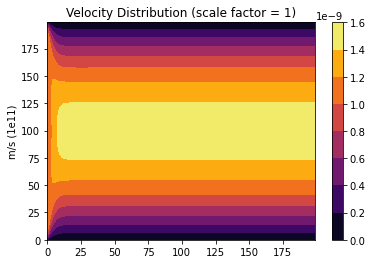

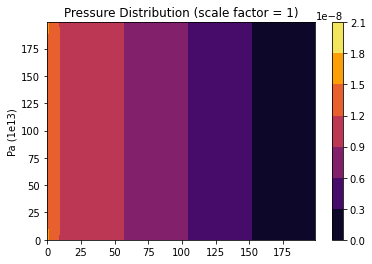

In [8]:
Lx = 0.1
Ly = 0.01
Nx =200
dx = Lx/Nx
Ny = 200
dy = Ly/Ny
max_its = 10
mu = 1e-6
tol = 1e-6
rho = 1050
vin = np.array([1e-9,0])
ScaleFactor = 1
ycoord = np.arange(dy/2,Ly,dy, dtype=float)
xcoord = np.arange(dx/2,Lx,dx, dtype=float)
vtk = False
vmag,p,v,u,iterations,residualsp,residualsvx, residualsvy,pressure_gradient = RieChowCFD(Lx,Ly,Nx,Ny,mu,rho, vin,ScaleFactor,max_its,tol,vtk)

# Gather Results

## Get Freestream Profile from previous simulation

In [245]:
def free_stream_section(vmag, per_cent, Nx): #per_cent is where to cut the cross section

    bot = math.ceil(Nx*per_cent) #middle cell bottom of block
    top = bot+Nx*Nx #middle cell top of block
    cells = np.arange(bot,top,Nx)#cells along middle of block
    vel_free = vmag[cells]
    return vel_free

## Analytical vs Numerical Free Stream Velocity Plot

Assuming simulation ran before

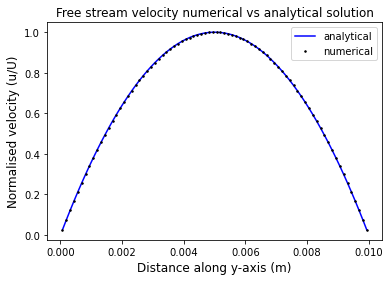

In [246]:
plt.figure()
vel_free  = free_stream_section(vmag, 0.7, Nx) #free stream values at 70% of cross section

plt.plot(ycoord, u/np.max(u), 'b',ycoord, vel_free/np.max(vel_free),'ko', markersize = 1.5)
plt.title('Free stream velocity numerical vs analytical solution', fontsize = 12, weight = 500)
plt.xlabel('Distance along y-axis (m)', fontsize = 12, weight = 500)
plt.ylabel('Normalised velocity (u/U)', fontsize = 12, weight = 500)
plt.legend(['analytical', 'numerical'])
plt.savefig('pvcopulingnumvsanalytical.png')

## Residual Error

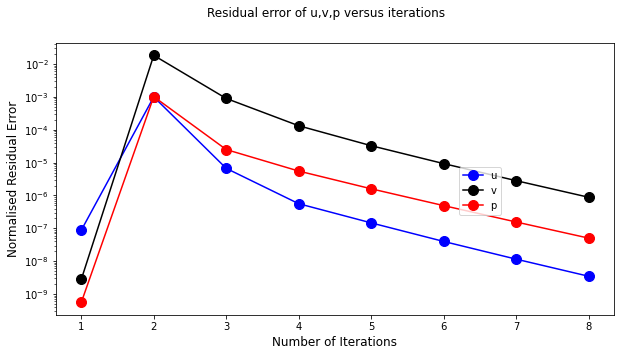

In [247]:
fig, ax1 = plt.subplots(figsize=(10, 5))
iters_array = np.arange(1,iterations+1)

ax1.plot(iters_array,residualsvx, 'b',iters_array,residualsvy, 'k',iters_array,residualsp,'r', marker = 'o',markersize = 10)
fig.legend(['u', 'v','p'],bbox_to_anchor=(0.75, 0.55))
fig.suptitle('Residual error of u,v,p versus iterations', fontsize = 12, weight = 500)
ax1.set_xlabel('Number of Iterations', fontsize = 12, weight = 500)
plt.yscale('log')
ax1.set_ylabel('Normalised Residual Error', fontsize = 12, weight = 500)
plt.savefig('residuals.png')

## Pressure across middle of channel

In [248]:
def PmidChannel(p,Nx,xcoord):
    
    #start 50% into channel for developed flow
    left = int(Nx/2)*Nx
    cells = np.arange(left,left+Nx)
    pmiddle = p[cells]
    
    return pmiddle
    

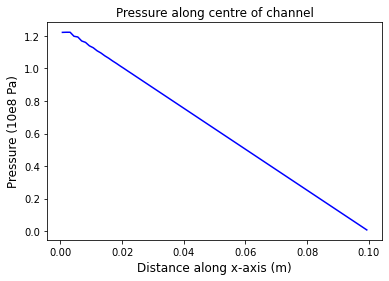

In [249]:
pmiddle = PmidChannel(p,Nx,xcoord)
mag = -orderOfMagnitude(pmiddle[0])
plt.figure()
plt.plot(xcoord, pmiddle*10**mag, 'b', markersize = 1.5)
plt.title('Pressure along centre of channel', fontsize = 12, weight = 500)
plt.xlabel('Distance along x-axis (m)', fontsize = 12, weight = 500)
plt.ylabel('Pressure (10e%i Pa)'%mag, fontsize = 12, weight = 500)
plt.savefig('pmidChannel.png')

## Discretisation Error

In [263]:
def diff_numerical_analytical(meshesx,meshesy):
    mses = []
    for num_cellsx,num_cellsy in zip(meshesx,meshesy):
#         print(num_cells)
#         print(Lx,Ly,num_cells,num_cells,mu,rho, vin,ScaleFactor,max_its,tol,vtk)
#         print(meshesx,meshesy)
        _,_,v,v_an,_,_,_, _,_ = RieChowCFD(Lx,Ly,num_cellsx,num_cellsy,mu,rho, vin,ScaleFactor,max_its,tol,vtk)
        
        vx = v[0::3].reshape(num_cellsx**2,1) #vy component
        v_num = free_stream_section(vx, 0.7, num_cellsx) #
        mse = ((v_an.reshape(num_cellsx,1) - v_num)**2).mean(axis=0)
        mses.append(mse)
        print(mse)
                    
    return np.array(mses)

## Run Code - WARNING LONG RUN TIME

Iterations, Residual vx, Residual vy, Residual p
1 1 1 1


2 0.002425616612096725 0.027972150321689 0.00242372276513751


3 1.2060514576896938e-05 0.0014272254737923587 2.6186627616588945e-05


4 9.669109904471873e-07 0.0002127326041549903 5.673832469634303e-06


5 2.413521206166798e-07 5.264674163699455e-05 1.6365115252632785e-06


6 6.509973500461392e-08 1.5014424637341976e-05 5.036502661629047e-07


7 1.875457531549686e-08 4.544557336620572e-06 1.5980555323378206e-07


8 5.647406946371074e-09 1.4211032333692177e-06 5.162051082053202e-08


9 1.7504304103316567e-09 4.535187318859496e-07 1.687055513849553e-08


tolerance reached in 10 iterations
Reynolds Number = 0.0105
[1.01082236e-16]
Iterations, Residual vx, Residual vy, Residual p
1 1 1 1


2 0.0006808818550412215 0.014984371790213061 0.0007222561894081272


3 5.503946676322316e-06 0.0007326372263852006 2.515658169919727e-05


4 4.52223413596312e-07 0.00010834866062766848 5.578075007848721e-06


5 1.1809438961008708e-07 2.674975467

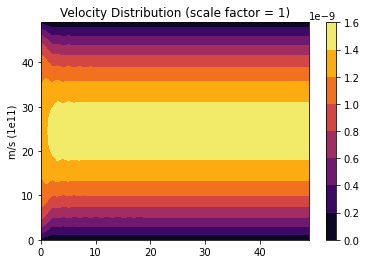

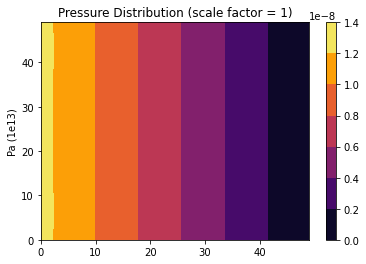

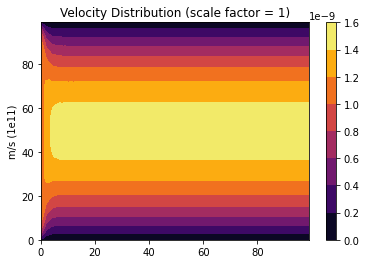

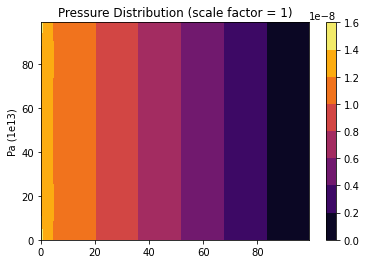

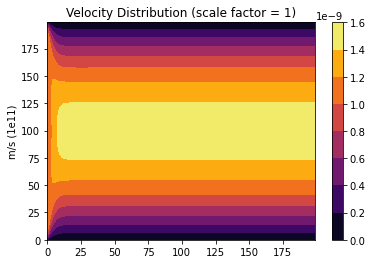

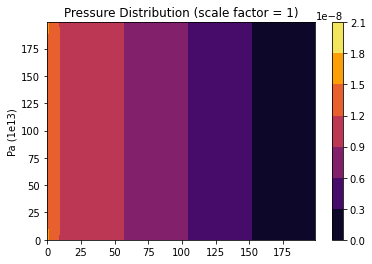

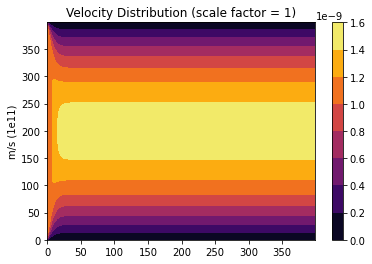

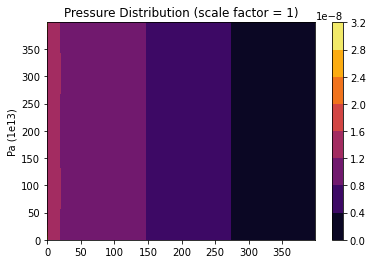

In [264]:

meshesx = np.array([50,100,200,400])
meshesy = meshesx
# mses = diff_numerical_analytical(meshesx,meshesy)

mses for previous run

In [287]:
mses = (np.array([1.01082236e-16,2.08708333e-17,3.09206572e-18,1.13518052e-19]))

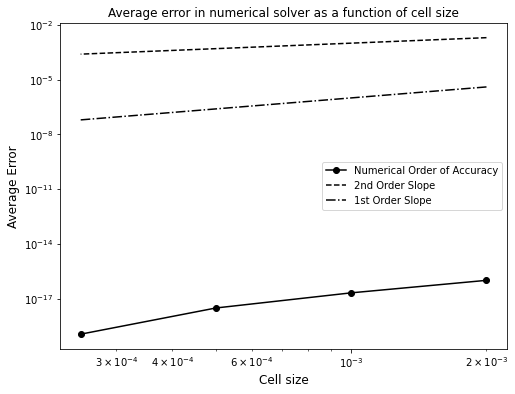

In [290]:

fig = plt.figure(figsize=(8,6))
scale = 1
plt.plot(Lx/meshesx,mses, color = 'k', marker = 'o')
plt.plot(Lx/meshesx/scale,Lx/meshesx, 'k--')
plt.plot(Lx/meshesx/scale,(Lx/meshesx)**2, 'k-.')
plt.xscale('log')
plt.yscale('log')
plt.title('Average error in numerical solver as a function of cell size', fontsize = 12, weight = 500)
plt.xlabel('Cell size', fontsize = 12, weight = 500)
plt.ylabel('Average Error', fontsize = 12, weight = 500)
plt.legend(['Numerical Order of Accuracy', '2nd Order Slope','1st Order Slope'],loc='center right')
plt.savefig('2nd order convergence.png')

## Output to VTK Format
